In [4]:
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [85]:
# Загрузим данные
df_data = pd.read_csv('uplift_synthetic_data_100trials.csv').iloc[: , 1:]
df_model = df_data.drop(["control_conversion_prob", "treatment1_conversion_prob", "treatment1_true_effect"], axis=1).copy()



In [86]:
df_data.head()

,trial_id,treatment_group_key,conversion,control_conversion_prob,treatment1_conversion_prob,treatment1_true_effect,x1_informative,x2_informative,x3_informative,x4_informative,...,x27_irrelevant,x28_irrelevant,x29_irrelevant,x30_irrelevant,x31_uplift_increase,x32_uplift_increase,x33_uplift_increase,x34_uplift_increase,x35_uplift_increase,x36_uplift_increase
0,0,control,1,0.516606,0.572609,0.056002,-1.926651,1.233472,-0.475120,0.081283,...,-0.378145,-0.110782,1.087180,-1.222069,-0.279009,1.013911,-0.570859,-1.158216,-1.336279,-0.708056
1,0,treatment1,1,0.304005,0.736460,0.432454,0.904364,0.868705,-0.285977,0.840136,...,-0.742847,0.700239,0.001867,-0.069362,0.045789,1.364182,-0.261643,0.478074,0.531477,0.402723
2,0,treatment1,0,0.134277,0.480985,0.346709,1.680978,1.320889,0.059273,-0.517732,...,0.748884,-0.856898,-0.268034,-2.181874,1.473214,-1.256641,0.901139,2.029204,-0.280445,0.873970
3,0,treatment1,1,0.801968,0.858532,0.056563,-0.335774,-2.940232,-0.302521,0.236998,...,0.151074,0.067547,-0.839246,0.587575,0.412081,0.141189,0.369611,-0.364984,-1.509045,-1.335023
4,0,control,0,0.063552,0.060142,-0.003410,-0.475881,-0.485793,0.978582,-0.610766,...,-1.287117,1.256396,-1.155307,-0.414787,1.163851,0.698114,0.088157,0.478717,-0.680588,-2.730850


In [87]:
# Проверим общую информацию о датасете (пропуски и типы данных)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 39 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   trial_id             1000000 non-null  int64  
 1   treatment_group_key  1000000 non-null  object 
 2   conversion           1000000 non-null  int64  
 3   x1_informative       1000000 non-null  float64
 4   x2_informative       1000000 non-null  float64
 5   x3_informative       1000000 non-null  float64
 6   x4_informative       1000000 non-null  float64
 7   x5_informative       1000000 non-null  float64
 8   x6_informative       1000000 non-null  float64
 9   x7_informative       1000000 non-null  float64
 10  x8_informative       1000000 non-null  float64
 11  x9_informative       1000000 non-null  float64
 12  x10_informative      1000000 non-null  float64
 13  x11_irrelevant       1000000 non-null  float64
 14  x12_irrelevant       1000000 non-null  float64
 15 

Видим, что пропусков в датасете нет.

In [88]:
# посмотрим сколько уникальных значений в  trial_id
df_model.trial_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
      dtype=int64)

In [89]:
#  В датасете выделена контрольная и целевая группа
df_model.treatment_group_key.unique()

array(['control', 'treatment1'], dtype=object)

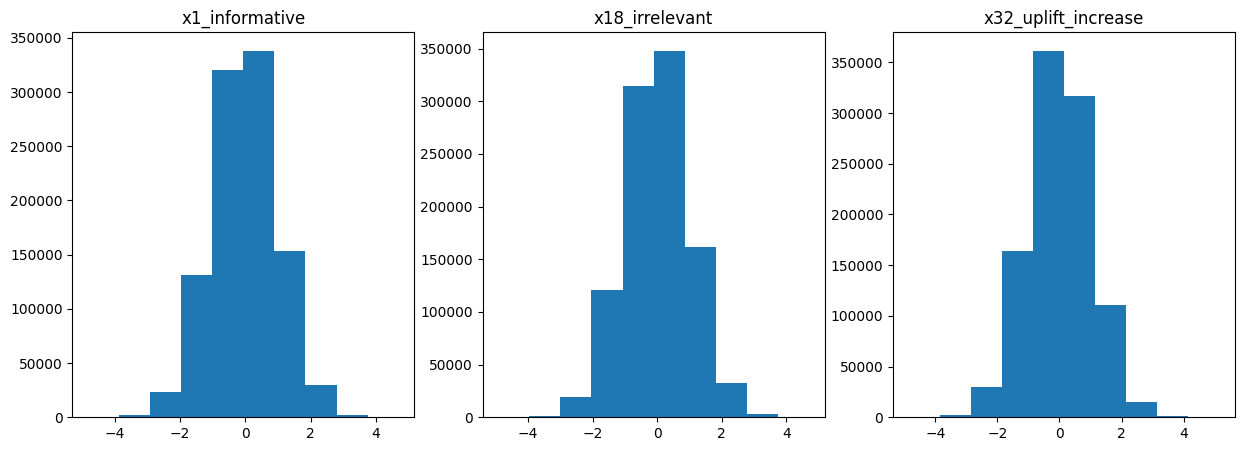

In [90]:
# посмотрим на распределения нескольких фичей из групп informative, irrelevant и uplift_increase
import matplotlib.pyplot as plt

df_feats = df_model[["x1_informative", "x18_irrelevant", "x32_uplift_increase"]]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for ind, feat in enumerate(df_feats.columns):

    ax[ind%3].hist(df_feats[feat])
    ax[ind%3].set_title(feat)
 

In [91]:
# Видно, что фичи распределены нормально

In [92]:
# посмотрим на распределение таргета в контрольной и целевой группе

df_model.groupby(["conversion", "treatment_group_key"])["trial_id"].count()

conversion  treatment_group_key
0           control                375736
            treatment1             320513
1           control                124264
            treatment1             179487
Name: trial_id, dtype: int64

## Предобработка данных

In [93]:
# Переименуем целевой признак (таргет) и столбец offer -> treatment
df_model = df_model.rename(columns={'conversion': 'target'})
df_model = df_model.rename(columns={'treatment_group_key': 'treatment'})
df_model.treatment = df_model.treatment.map({'control': 0, 'treatment1': 1})

## Определим классы клиентов

* <h3> Control Non-Responders(CN) </h3>
Клиенты, которые не сделают заказ без акции/воздействия (value = 0)

* <h3> Control Responders(CR) </h3>
Клиенты, которые сделают заказ без акции/воздействия(value = 1)

* <h3> Treatment Non-Responders(TN) </h3>
Клиенты, которые не сделали заказ и приняли акционное предложение (value = 2)

* <h3> Treatment Responders(TR) </h3>
Клиенты, которые сделали заказ и приняли акционное предложение (value = 3)








In [94]:
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3
    return df

In [96]:
df_model = declare_tc(df_model)

## Uplift Modeling
Мы используем Lai’s Generalized Weighed Uplift (LGWUM) для оценки uplift score.
<br>LGWUM один из подходов (https://www.worldscientific.com/doi/abs/10.1142/S0219622019500172) используемых в Uplift Modeling (https://dl.acm.org/doi/abs/10.1145/772862.772872). Обозначим за P вероятность, T обозначает общее число клиентов, на которых воздействовали (TR + TN), а C обозначает общее число клиентов на которых не совершали маркетингового воздействия (CR + CN).
В этом случае Uplift Score может быть вычислена как:
> **Uplift Score = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)**


In [97]:
# Functions for Uplift
from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    """Train-Test Split
    """
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, \
    y_train, y_test  = train_test_split(X,
                                       y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test


def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    """Using XGB to get the uplift score
    """
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()
    # Fit the model
    uplift_model \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)


    # Predict using test-data
    uplift_proba \
    = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0]
    result['proba_CR'] = uplift_proba[:,1]
    result['proba_TN'] = uplift_proba[:,2]
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')
    # Put the result
    result['target_class'] = y_test
    return result


def uplift(df_model:pd.DataFrame):
    """Combine the split and Modeling function
    """
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [98]:
treat_uplift = uplift(df_model)

# Оценка модели - кривая QINI
QINI (Uplift value) вычислыется как:
> **QINI = TR - [(CR*T)/C]**

или в процентах:
> **QINI = (TR/T) - (CR/C)**

In [100]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']


    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)


    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])


    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

# Результаты
Кривая QINI показывает, что применение uplift модели для выбора клиентов для взаимодействия показывает лучшие результаты чем случайная модель.

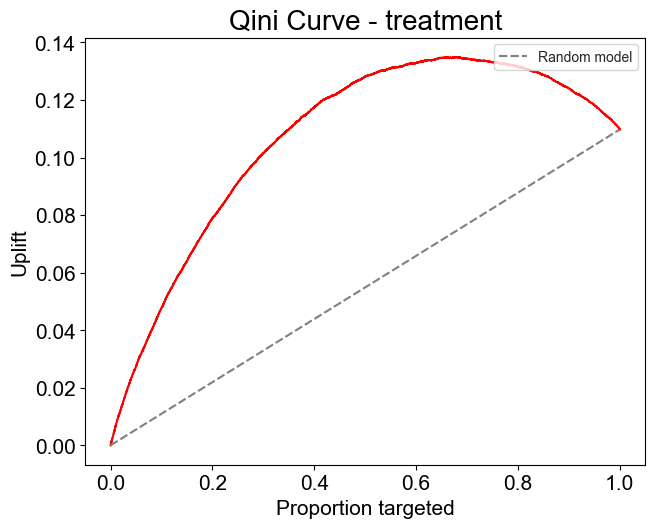

In [102]:
# plot the Qini curve for treatment
qini(treat_uplift)
plt.title('Qini Curve - treatment',fontsize=20)